In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '4'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_only_conv_pool_3_ch_64_DO(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=25, filters=64, strides=1, 
                      activation='relu', input_shape=input_shape)) 
#     model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=25, filters=64*(2**int((i+1)/2)), strides=1, 
                          activation='relu'))
#         model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))

    model.add(Flatten())
    
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax'))
    
    return model

In [9]:
for i in range(1, 7):
    model = build_1d_cnn_only_conv_pool_3_ch_64_DO(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 15976, 64)         1664      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 5326, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 340864)            0         
_________________________________________________________________
dropout (Dropout)            (None, 340864)            0         
_________________________________________________________________
dense (Dense)                (None, 16)                5453840   
Total params: 5,455,504
Trainable params: 5,455,504
Non-trainable params: 0
___________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 15976, 64)         1664      
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 5326, 64)          0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 5302, 64)          102464    
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 1768, 64)          0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 1744, 128)         204928    
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 582, 128)          0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 558, 128)          409728    
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1308 - acc: 0.3425
Epoch 00001: val_loss improved from inf to 1.73620, saving model to model/checkpoint/1D_CNN_1_only_conv_pool_3_ch_64_DO_checkpoint/001-1.7362.hdf5
36805/36805 [==============================] - 24s 645us/sample - loss: 2.1308 - acc: 0.3425 - val_loss: 1.7362 - val_acc: 0.4563
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5116 - acc: 0.5400
Epoch 00002: val_loss improved from 1.73620 to 1.56029, saving model to model/checkpoint/1D_CNN_1_only_conv_pool_3_ch_64_DO_checkpoint/002-1.5603.hdf5
36805/36805 [==============================] - 22s 596us/sample - loss: 1.5116 - acc: 0.5400 - val_loss: 1.5603 - val_acc: 0.5059
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2708 - acc: 0.6144
Epoch 00003: val_loss improved from 1.56029 to 1.49301, s

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1730 - acc: 0.9615
Epoch 00029: val_loss did not improve from 1.49301
36805/36805 [==============================] - 22s 590us/sample - loss: 0.1731 - acc: 0.9615 - val_loss: 2.2762 - val_acc: 0.5197
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1655 - acc: 0.9639
Epoch 00030: val_loss did not improve from 1.49301
36805/36805 [==============================] - 22s 588us/sample - loss: 0.1655 - acc: 0.9639 - val_loss: 2.3137 - val_acc: 0.5220
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1555 - acc: 0.9667
Epoch 00031: val_loss did not improve from 1.49301
36805/36805 [==============================] - 22s 595us/sample - loss: 0.1555 - acc: 0.9667 - val_loss: 2.3523 - val_acc: 0.5199
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1523 - acc: 0.9673
Epoch 00032: val_loss did not improve from 1.49301
36805/36805 [=====

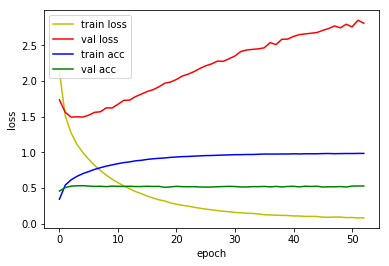

4815/4815 [==============================] - 2s 312us/sample - loss: 1.5939 - acc: 0.4945
Loss: 1.5939404544305456 Accuracy: 0.49449638

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9170 - acc: 0.3876
Epoch 00001: val_loss improved from inf to 1.47665, saving model to model/checkpoint/1D_CNN_2_only_conv_pool_3_ch_64_DO_checkpoint/001-1.4766.hdf5
36805/36805 [==============================] - 35s 948us/sample - loss: 1.9169 - acc: 0.3876 - val_loss: 1.4766 - val_acc: 0.5516
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3491 - acc: 0.5845
Epoch 00002: val_loss improved from 1.47665 to 1.26287, saving model to model/checkpoint/1D_CNN_2_only_conv_pool_3_ch_64_DO_checkpoint/002-1.2629.hdf5
36805/36805 [==============================] - 34s 913us/sample - loss: 1.3491 - acc: 0.5845 - val_loss: 1.2629 - val_acc: 0.6136
Epoch 3/500
36800/36805 [============================>.] - ETA: 

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0423 - acc: 0.9902
Epoch 00057: val_loss did not improve from 1.06572
36805/36805 [==============================] - 33s 907us/sample - loss: 0.0423 - acc: 0.9902 - val_loss: 1.7683 - val_acc: 0.7123

1D_CNN_2_only_conv_pool_3_ch_64_DO Model


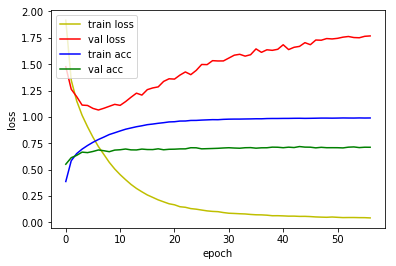

4815/4815 [==============================] - 2s 403us/sample - loss: 1.1889 - acc: 0.6372
Loss: 1.188891539024044 Accuracy: 0.6371755

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8564 - acc: 0.4066
Epoch 00001: val_loss improved from inf to 1.32802, saving model to model/checkpoint/1D_CNN_3_only_conv_pool_3_ch_64_DO_checkpoint/001-1.3280.hdf5
36805/36805 [==============================] - 42s 1ms/sample - loss: 1.8563 - acc: 0.4067 - val_loss: 1.3280 - val_acc: 0.5996
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2476 - acc: 0.6209
Epoch 00002: val_loss improved from 1.32802 to 1.04511, saving model to model/checkpoint/1D_CNN_3_only_conv_pool_3_ch_64_DO_checkpoint/002-1.0451.hdf5
36805/36805 [==============================] - 41s 1ms/sample - loss: 1.2477 - acc: 0.6209 - val_loss: 1.0451 - val_acc: 0.6939
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - l

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0256 - acc: 0.9946
Epoch 00056: val_loss did not improve from 0.57782
36805/36805 [==============================] - 41s 1ms/sample - loss: 0.0256 - acc: 0.9946 - val_loss: 0.9167 - val_acc: 0.8626
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0317 - acc: 0.9922
Epoch 00057: val_loss did not improve from 0.57782
36805/36805 [==============================] - 41s 1ms/sample - loss: 0.0317 - acc: 0.9922 - val_loss: 0.9537 - val_acc: 0.8512
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0232 - acc: 0.9952
Epoch 00058: val_loss did not improve from 0.57782
36805/36805 [==============================] - 41s 1ms/sample - loss: 0.0232 - acc: 0.9952 - val_loss: 0.9848 - val_acc: 0.8505
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0267 - acc: 0.9932
Epoch 00059: val_loss did not improve from 0.57782
36805/36805 [===========

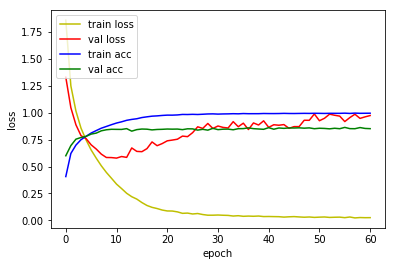

4815/4815 [==============================] - 2s 454us/sample - loss: 0.6735 - acc: 0.8066
Loss: 0.6735462886398331 Accuracy: 0.8066459

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9467 - acc: 0.3669
Epoch 00001: val_loss improved from inf to 1.32052, saving model to model/checkpoint/1D_CNN_4_only_conv_pool_3_ch_64_DO_checkpoint/001-1.3205.hdf5
36805/36805 [==============================] - 47s 1ms/sample - loss: 1.9467 - acc: 0.3669 - val_loss: 1.3205 - val_acc: 0.5938
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2394 - acc: 0.6201
Epoch 00002: val_loss improved from 1.32052 to 0.99798, saving model to model/checkpoint/1D_CNN_4_only_conv_pool_3_ch_64_DO_checkpoint/002-0.9980.hdf5
36805/36805 [==============================] - 45s 1ms/sample - loss: 1.2394 - acc: 0.6201 - val_loss: 0.9980 - val_acc: 0.7093
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - 

Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0362 - acc: 0.9893
Epoch 00054: val_loss did not improve from 0.30051
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.0362 - acc: 0.9893 - val_loss: 0.4196 - val_acc: 0.9297
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0367 - acc: 0.9890
Epoch 00055: val_loss did not improve from 0.30051
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.0367 - acc: 0.9890 - val_loss: 0.4307 - val_acc: 0.9324
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0320 - acc: 0.9903
Epoch 00056: val_loss did not improve from 0.30051
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.0320 - acc: 0.9903 - val_loss: 0.4348 - val_acc: 0.9338
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0366 - acc: 0.9890
Epoch 00057: val_loss did not improve from 0.30051
36805/36805 [===========

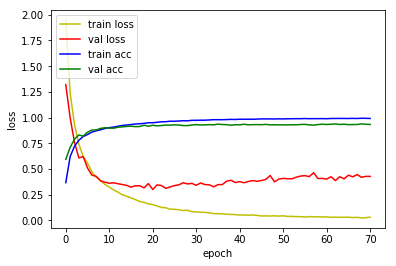

4815/4815 [==============================] - 2s 489us/sample - loss: 0.3800 - acc: 0.8945
Loss: 0.38002277769898823 Accuracy: 0.8944964

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8354 - acc: 0.3974
Epoch 00001: val_loss improved from inf to 1.02662, saving model to model/checkpoint/1D_CNN_5_only_conv_pool_3_ch_64_DO_checkpoint/001-1.0266.hdf5
36805/36805 [==============================] - 50s 1ms/sample - loss: 1.8353 - acc: 0.3974 - val_loss: 1.0266 - val_acc: 0.6785
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9579 - acc: 0.7002
Epoch 00002: val_loss improved from 1.02662 to 0.62129, saving model to model/checkpoint/1D_CNN_5_only_conv_pool_3_ch_64_DO_checkpoint/002-0.6213.hdf5
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.9582 - acc: 0.7002 - val_loss: 0.6213 - val_acc: 0.8106
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s -

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0634 - acc: 0.9783
Epoch 00026: val_loss did not improve from 0.17178
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.0634 - acc: 0.9783 - val_loss: 0.1932 - val_acc: 0.9546
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0616 - acc: 0.9799
Epoch 00027: val_loss did not improve from 0.17178
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.0616 - acc: 0.9799 - val_loss: 0.2064 - val_acc: 0.9541
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0548 - acc: 0.9816
Epoch 00028: val_loss did not improve from 0.17178
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.0548 - acc: 0.9816 - val_loss: 0.1866 - val_acc: 0.9555
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0532 - acc: 0.9824
Epoch 00029: val_loss did not improve from 0.17178
36805/36805 [===========

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0217 - acc: 0.9932
Epoch 00056: val_loss did not improve from 0.17178
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.0217 - acc: 0.9932 - val_loss: 0.2101 - val_acc: 0.9599
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0232 - acc: 0.9925
Epoch 00057: val_loss did not improve from 0.17178
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.0232 - acc: 0.9925 - val_loss: 0.2360 - val_acc: 0.9578
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0171 - acc: 0.9946
Epoch 00058: val_loss did not improve from 0.17178
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.0171 - acc: 0.9946 - val_loss: 0.2760 - val_acc: 0.9543
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0242 - acc: 0.9921
Epoch 00059: val_loss did not improve from 0.17178
36805/36805 [===========

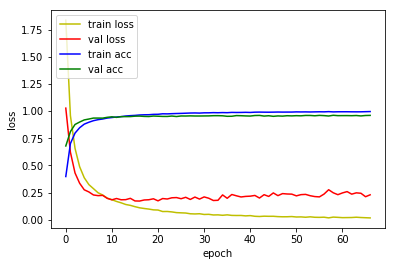

4815/4815 [==============================] - 2s 515us/sample - loss: 0.2164 - acc: 0.9356
Loss: 0.2164164925259098 Accuracy: 0.93561786

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7614 - acc: 0.4212
Epoch 00001: val_loss improved from inf to 0.90588, saving model to model/checkpoint/1D_CNN_6_only_conv_pool_3_ch_64_DO_checkpoint/001-0.9059.hdf5
36805/36805 [==============================] - 53s 1ms/sample - loss: 1.7613 - acc: 0.4212 - val_loss: 0.9059 - val_acc: 0.7095
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8735 - acc: 0.7180
Epoch 00002: val_loss improved from 0.90588 to 0.58576, saving model to model/checkpoint/1D_CNN_6_only_conv_pool_3_ch_64_DO_checkpoint/002-0.5858.hdf5
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.8734 - acc: 0.7181 - val_loss: 0.5858 - val_acc: 0.8181
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s -

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0207 - acc: 0.9938
Epoch 00056: val_loss did not improve from 0.15493
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.0207 - acc: 0.9938 - val_loss: 0.2510 - val_acc: 0.9578
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0214 - acc: 0.9937
Epoch 00057: val_loss did not improve from 0.15493
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.0214 - acc: 0.9938 - val_loss: 0.2067 - val_acc: 0.9618
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0158 - acc: 0.9951
Epoch 00058: val_loss did not improve from 0.15493
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.0158 - acc: 0.9951 - val_loss: 0.2302 - val_acc: 0.9588
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0197 - acc: 0.9941
Epoch 00059: val_loss did not improve from 0.15493
36805/36805 [===========

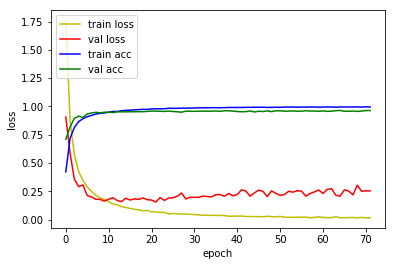

4815/4815 [==============================] - 3s 560us/sample - loss: 0.2123 - acc: 0.9479
Loss: 0.21225319082170788 Accuracy: 0.9478712



In [10]:
for i in range(1, 7):
    model_name = '1D_CNN_{}_only_conv_pool_3_ch_64_DO'.format(i)
    model = build_1d_cnn_only_conv_pool_3_ch_64_DO(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
for i in range(1, 7):
    model_name = '1D_CNN_{}_only_conv_pool_3_ch_64_DO'.format(i)
    print()
    print(model_name, 'Model')
#         model = build_cnn(conv_num=i, fcn_num=j)
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
#         model_filename = model_path + '{epoch:02d}-{val_loss:.4f}.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


1D_CNN_1_only_conv_pool_3_ch_64_DO Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_21 (Conv1D)           (None, 15976, 64)         1664      
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 5326, 64)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 340864)            0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 340864)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                5453840   
Total params: 5,455,504
Trainable params: 5,455,504
Non-trainable params: 0
_________________________________________________________________
4815/4815 [==============================] - 2s 330us/sample - loss: 1.5939 - acc: 0.4945


4815/4815 [==============================] - 3s 545us/sample - loss: 0.2164 - acc: 0.9356
Loss: 0.2164164925259098 Accuracy: 0.93561786

1D_CNN_6_only_conv_pool_3_ch_64_DO Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_36 (Conv1D)           (None, 15976, 64)         1664      
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 5326, 64)          0         
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 5302, 64)          102464    
_________________________________________________________________
max_pooling1d_37 (MaxPooling (None, 1768, 64)          0         
_________________________________________________________________
conv1d_38 (Conv1D)           (None, 1744, 128)         204928    
_________________________________________________________________
max_pooling1d_38 (MaxPooling (

In [12]:
def build_1d_cnn_only_conv_pool_3_ch_64_BN(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=25, filters=64, strides=1, input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=25, filters=64*(2**int((i+1)/2)), strides=1))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))

    model.add(Flatten())
    
#     model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax'))
    
    return model

In [13]:
for i in range(1, 7):
    model = build_1d_cnn_only_conv_pool_3_ch_64_BN(conv_num=i)
    model.summary()
    del model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42 (Conv1D)           (None, 15976, 64)         1664      
_________________________________________________________________
batch_normalization_v1 (Batc (None, 15976, 64)         256       
_________________________________________________________________
max_pooling1d_42 (MaxPooling (None, 5326, 64)          0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 340864)            0         
_________________________________________________________________
dense_12 (Dense)             (None, 16)                5453840   
Total params: 5,455,760
Trainable params: 5,455,632
Non-trainable params: 128
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_57 (Conv1D)           (None, 15976, 64)         1664      
_________________________________________________________________
batch_normalization_v1_15 (B (None, 15976, 64)         256       
_________________________________________________________________
max_pooling1d_57 (MaxPooling (None, 5326, 64)          0         
_________________________________________________________________
conv1d_58 (Conv1D)           (None, 5302, 64)          102464    
_________________________________________________________________
batch_normalization_v1_16 (B (None, 5302, 64)          256       
_________________________________________________________________
max_pooling1d_58 (MaxPooling (None, 1768, 64)          0         
_________________________________________________________________
conv1d_59 (Conv1D)           (None, 1744, 128)         204928    
__________

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0954 - acc: 0.3968
Epoch 00001: val_loss improved from inf to 1.74412, saving model to model/checkpoint/1D_CNN_1_only_conv_pool_3_ch_64_BN_checkpoint/001-1.7441.hdf5
36805/36805 [==============================] - 39s 1ms/sample - loss: 2.0953 - acc: 0.3968 - val_loss: 1.7441 - val_acc: 0.4587
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1072 - acc: 0.6579
Epoch 00002: val_loss did not improve from 1.74412
36805/36805 [==============================] - 34s 918us/sample - loss: 1.1073 - acc: 0.6578 - val_loss: 1.7655 - val_acc: 0.4941
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7575 - acc: 0.7697
Epoch 00003: val_loss did not improve from 1.74412
36805/36805 [==============================] - 34s 919us/sample - loss: 0.7576 - acc: 0.7697 - val_loss: 1.7995 - val_acc: 0.5248
Epoch 4/500
36800/36805 [=

Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0661 - acc: 0.9854
Epoch 00030: val_loss did not improve from 1.74412
36805/36805 [==============================] - 34s 918us/sample - loss: 0.0661 - acc: 0.9854 - val_loss: 4.1750 - val_acc: 0.4868
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0479 - acc: 0.9906
Epoch 00031: val_loss did not improve from 1.74412
36805/36805 [==============================] - 34s 917us/sample - loss: 0.0479 - acc: 0.9906 - val_loss: 5.2776 - val_acc: 0.4198
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0666 - acc: 0.9867
Epoch 00032: val_loss did not improve from 1.74412
36805/36805 [==============================] - 34s 918us/sample - loss: 0.0666 - acc: 0.9867 - val_loss: 4.2450 - val_acc: 0.4980
Epoch 33/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0397 - acc: 0.9939
Epoch 00033: val_loss did not improve from 1.74412
36805/36805 [=====

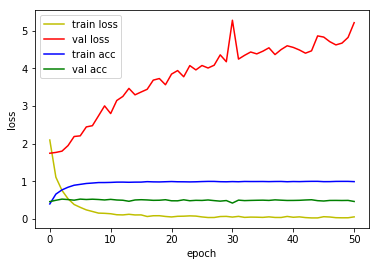

4815/4815 [==============================] - 2s 491us/sample - loss: 1.8044 - acc: 0.4353
Loss: 1.8044004320726958 Accuracy: 0.43530634

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4481 - acc: 0.4390
Epoch 00001: val_loss improved from inf to 3.29258, saving model to model/checkpoint/1D_CNN_2_only_conv_pool_3_ch_64_BN_checkpoint/001-3.2926.hdf5
36805/36805 [==============================] - 58s 2ms/sample - loss: 2.4481 - acc: 0.4390 - val_loss: 3.2926 - val_acc: 0.3359
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1156 - acc: 0.7121
Epoch 00002: val_loss improved from 3.29258 to 2.23832, saving model to model/checkpoint/1D_CNN_2_only_conv_pool_3_ch_64_BN_checkpoint/002-2.2383.hdf5
36805/36805 [==============================] - 52s 1ms/sample - loss: 1.1154 - acc: 0.7122 - val_loss: 2.2383 - val_acc: 0.5341
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s -

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0624 - acc: 0.9895
Epoch 00029: val_loss did not improve from 1.89676
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0624 - acc: 0.9895 - val_loss: 3.2342 - val_acc: 0.6396
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0555 - acc: 0.9915
Epoch 00030: val_loss did not improve from 1.89676
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0555 - acc: 0.9915 - val_loss: 3.3495 - val_acc: 0.6408
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0554 - acc: 0.9910
Epoch 00031: val_loss did not improve from 1.89676
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0554 - acc: 0.9910 - val_loss: 3.5237 - val_acc: 0.6245
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0586 - acc: 0.9909
Epoch 00032: val_loss did not improve from 1.89676
36805/36805 [===========

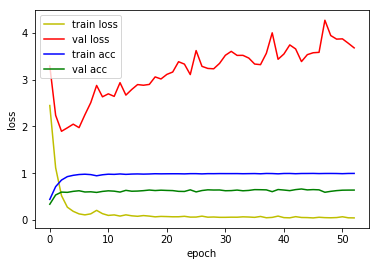

4815/4815 [==============================] - 3s 616us/sample - loss: 1.9160 - acc: 0.5801
Loss: 1.9159575004072575 Accuracy: 0.5800623

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0027 - acc: 0.5086
Epoch 00001: val_loss improved from inf to 7.35778, saving model to model/checkpoint/1D_CNN_3_only_conv_pool_3_ch_64_BN_checkpoint/001-7.3578.hdf5
36805/36805 [==============================] - 70s 2ms/sample - loss: 2.0025 - acc: 0.5086 - val_loss: 7.3578 - val_acc: 0.2103
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0436 - acc: 0.7248
Epoch 00002: val_loss improved from 7.35778 to 1.43892, saving model to model/checkpoint/1D_CNN_3_only_conv_pool_3_ch_64_BN_checkpoint/002-1.4389.hdf5
36805/36805 [==============================] - 62s 2ms/sample - loss: 1.0436 - acc: 0.7248 - val_loss: 1.4389 - val_acc: 0.6580
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - 

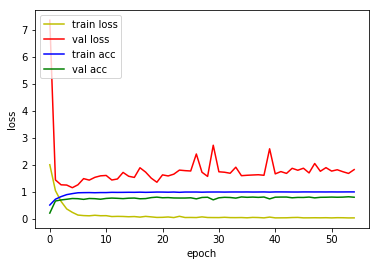

4815/4815 [==============================] - 3s 715us/sample - loss: 1.2824 - acc: 0.7130
Loss: 1.2823538812150093 Accuracy: 0.7129803

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4168 - acc: 0.5745
Epoch 00001: val_loss improved from inf to 6.05956, saving model to model/checkpoint/1D_CNN_4_only_conv_pool_3_ch_64_BN_checkpoint/001-6.0596.hdf5
36805/36805 [==============================] - 78s 2ms/sample - loss: 1.4170 - acc: 0.5745 - val_loss: 6.0596 - val_acc: 0.2285
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7326 - acc: 0.7838
Epoch 00002: val_loss improved from 6.05956 to 0.84312, saving model to model/checkpoint/1D_CNN_4_only_conv_pool_3_ch_64_BN_checkpoint/002-0.8431.hdf5
36805/36805 [==============================] - 68s 2ms/sample - loss: 0.7326 - acc: 0.7838 - val_loss: 0.8431 - val_acc: 0.7480
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - 

Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0155 - acc: 0.9960
Epoch 00058: val_loss did not improve from 0.46186
36805/36805 [==============================] - 68s 2ms/sample - loss: 0.0155 - acc: 0.9960 - val_loss: 0.6424 - val_acc: 0.8996
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0112 - acc: 0.9973
Epoch 00059: val_loss did not improve from 0.46186
36805/36805 [==============================] - 68s 2ms/sample - loss: 0.0112 - acc: 0.9973 - val_loss: 1.3078 - val_acc: 0.8241
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0134 - acc: 0.9964
Epoch 00060: val_loss did not improve from 0.46186
36805/36805 [==============================] - 68s 2ms/sample - loss: 0.0135 - acc: 0.9963 - val_loss: 0.5953 - val_acc: 0.9085
Epoch 61/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0171 - acc: 0.9954
Epoch 00061: val_loss did not improve from 0.46186
36805/36805 [===========

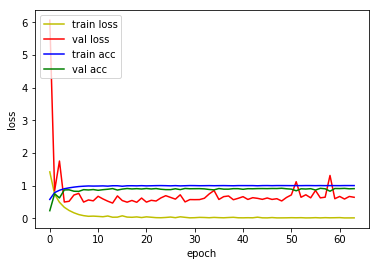

4815/4815 [==============================] - 4s 768us/sample - loss: 0.5327 - acc: 0.8785
Loss: 0.5326872288004756 Accuracy: 0.8785047

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2253 - acc: 0.6256
Epoch 00001: val_loss improved from inf to 3.96079, saving model to model/checkpoint/1D_CNN_5_only_conv_pool_3_ch_64_BN_checkpoint/001-3.9608.hdf5
36805/36805 [==============================] - 85s 2ms/sample - loss: 1.2252 - acc: 0.6256 - val_loss: 3.9608 - val_acc: 0.2427
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5061 - acc: 0.8502
Epoch 00002: val_loss improved from 3.96079 to 0.45465, saving model to model/checkpoint/1D_CNN_5_only_conv_pool_3_ch_64_BN_checkpoint/002-0.4547.hdf5
36805/36805 [==============================] - 72s 2ms/sample - loss: 0.5064 - acc: 0.8501 - val_loss: 0.4547 - val_acc: 0.8761
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - 

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0143 - acc: 0.9956
Epoch 00028: val_loss did not improve from 0.23547
36805/36805 [==============================] - 72s 2ms/sample - loss: 0.0144 - acc: 0.9956 - val_loss: 0.3010 - val_acc: 0.9371
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0240 - acc: 0.9926
Epoch 00029: val_loss did not improve from 0.23547
36805/36805 [==============================] - 72s 2ms/sample - loss: 0.0240 - acc: 0.9926 - val_loss: 0.2867 - val_acc: 0.9415
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0160 - acc: 0.9950
Epoch 00030: val_loss did not improve from 0.23547
36805/36805 [==============================] - 72s 2ms/sample - loss: 0.0162 - acc: 0.9950 - val_loss: 0.3375 - val_acc: 0.9306
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0220 - acc: 0.9930
Epoch 00031: val_loss did not improve from 0.23547
36805/36805 [===========

Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0078 - acc: 0.9975
Epoch 00087: val_loss did not improve from 0.22802
36805/36805 [==============================] - 72s 2ms/sample - loss: 0.0078 - acc: 0.9974 - val_loss: 0.3030 - val_acc: 0.9502
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0036 - acc: 0.9988
Epoch 00088: val_loss did not improve from 0.22802
36805/36805 [==============================] - 72s 2ms/sample - loss: 0.0036 - acc: 0.9988 - val_loss: 0.2861 - val_acc: 0.9515
Epoch 89/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0037 - acc: 0.9987
Epoch 00089: val_loss did not improve from 0.22802
36805/36805 [==============================] - 72s 2ms/sample - loss: 0.0037 - acc: 0.9988 - val_loss: 0.3382 - val_acc: 0.9439
Epoch 90/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0037 - acc: 0.9990
Epoch 00090: val_loss did not improve from 0.22802
36805/36805 [===========

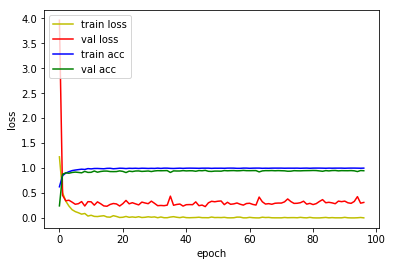

4815/4815 [==============================] - 4s 820us/sample - loss: 0.3357 - acc: 0.9377
Loss: 0.33574463050127773 Accuracy: 0.9376947

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0132 - acc: 0.6881
Epoch 00001: val_loss improved from inf to 2.26093, saving model to model/checkpoint/1D_CNN_6_only_conv_pool_3_ch_64_BN_checkpoint/001-2.2609.hdf5
36805/36805 [==============================] - 92s 2ms/sample - loss: 1.0131 - acc: 0.6882 - val_loss: 2.2609 - val_acc: 0.3937
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3985 - acc: 0.8775
Epoch 00002: val_loss improved from 2.26093 to 0.34251, saving model to model/checkpoint/1D_CNN_6_only_conv_pool_3_ch_64_BN_checkpoint/002-0.3425.hdf5
36805/36805 [==============================] - 75s 2ms/sample - loss: 0.3985 - acc: 0.8775 - val_loss: 0.3425 - val_acc: 0.8931
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s -

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0143 - acc: 0.9962
Epoch 00027: val_loss did not improve from 0.16484
36805/36805 [==============================] - 75s 2ms/sample - loss: 0.0144 - acc: 0.9962 - val_loss: 0.1782 - val_acc: 0.9532
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0179 - acc: 0.9950
Epoch 00028: val_loss did not improve from 0.16484
36805/36805 [==============================] - 75s 2ms/sample - loss: 0.0179 - acc: 0.9950 - val_loss: 0.1847 - val_acc: 0.9536
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0099 - acc: 0.9976
Epoch 00029: val_loss did not improve from 0.16484
36805/36805 [==============================] - 75s 2ms/sample - loss: 0.0099 - acc: 0.9976 - val_loss: 0.1856 - val_acc: 0.9536
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0135 - acc: 0.9968
Epoch 00030: val_loss did not improve from 0.16484
36805/36805 [===========

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0089 - acc: 0.9977
Epoch 00057: val_loss did not improve from 0.16484
36805/36805 [==============================] - 75s 2ms/sample - loss: 0.0089 - acc: 0.9977 - val_loss: 0.1752 - val_acc: 0.9583
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0039 - acc: 0.9989
Epoch 00058: val_loss did not improve from 0.16484
36805/36805 [==============================] - 75s 2ms/sample - loss: 0.0039 - acc: 0.9989 - val_loss: 0.1844 - val_acc: 0.9597
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0024 - acc: 0.9994
Epoch 00059: val_loss did not improve from 0.16484
36805/36805 [==============================] - 75s 2ms/sample - loss: 0.0024 - acc: 0.9994 - val_loss: 0.1755 - val_acc: 0.9613
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0016 - acc: 0.9996
Epoch 00060: val_loss did not improve from 0.16484
36805/36805 [===========

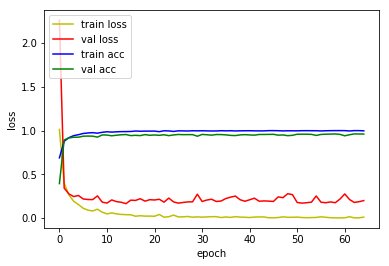

4815/4815 [==============================] - 4s 893us/sample - loss: 0.2102 - acc: 0.9414
Loss: 0.21017093617287255 Accuracy: 0.941433



In [14]:
for i in range(1, 7):
    model_name = '1D_CNN_{}_only_conv_pool_3_ch_64_BN'.format(i)
    model = build_1d_cnn_only_conv_pool_3_ch_64_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [15]:
for i in range(1, 7):
    model_name = '1D_CNN_{}_only_conv_pool_3_ch_64_BN'.format(i)
    print()
    print(model_name, 'Model')
#         model = build_cnn(conv_num=i, fcn_num=j)
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
#         model_filename = model_path + '{epoch:02d}-{val_loss:.4f}.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


1D_CNN_1_only_conv_pool_3_ch_64_BN Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_63 (Conv1D)           (None, 15976, 64)         1664      
_________________________________________________________________
batch_normalization_v1_21 (B (None, 15976, 64)         256       
_________________________________________________________________
max_pooling1d_63 (MaxPooling (None, 5326, 64)          0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 340864)            0         
_________________________________________________________________
dense_18 (Dense)             (None, 16)                5453840   
Total params: 5,455,760
Trainable params: 5,455,632
Non-trainable params: 128
_________________________________________________________________
4815/4815 [==============================] - 3s 637us/sample - loss: 1.8044 - acc: 0.435

4815/4815 [==============================] - 4s 915us/sample - loss: 0.3357 - acc: 0.9377
Loss: 0.33574463050127773 Accuracy: 0.9376947

1D_CNN_6_only_conv_pool_3_ch_64_BN Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_78 (Conv1D)           (None, 15976, 64)         1664      
_________________________________________________________________
batch_normalization_v1_36 (B (None, 15976, 64)         256       
_________________________________________________________________
max_pooling1d_78 (MaxPooling (None, 5326, 64)          0         
_________________________________________________________________
conv1d_79 (Conv1D)           (None, 5302, 64)          102464    
_________________________________________________________________
batch_normalization_v1_37 (B (None, 5302, 64)          256       
_________________________________________________________________
max_pooling1d_79 (MaxPooling (

In [16]:
def build_1d_cnn_only_conv_pool_3_ch_64_DO_BN(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=25, filters=64, strides=1, input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=25, filters=64*(2**int((i+1)/2)), strides=1))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))

    model.add(Flatten())
    
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax'))
    
    return model

In [17]:
for i in range(1, 7):
    model = build_1d_cnn_only_conv_pool_3_ch_64_DO_BN(conv_num=i)
    model.summary()
    del model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_84 (Conv1D)           (None, 15976, 64)         1664      
_________________________________________________________________
batch_normalization_v1_42 (B (None, 15976, 64)         256       
_________________________________________________________________
max_pooling1d_84 (MaxPooling (None, 5326, 64)          0         
_________________________________________________________________
flatten_24 (Flatten)         (None, 340864)            0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 340864)            0         
_________________________________________________________________
dense_24 (Dense)             (None, 16)                5453840   
Total params: 5,455,760
Trainable params: 5,455,632
Non-trainable params: 128
________________________________________________________________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_99 (Conv1D)           (None, 15976, 64)         1664      
_________________________________________________________________
batch_normalization_v1_57 (B (None, 15976, 64)         256       
_________________________________________________________________
max_pooling1d_99 (MaxPooling (None, 5326, 64)          0         
_________________________________________________________________
conv1d_100 (Conv1D)          (None, 5302, 64)          102464    
_________________________________________________________________
batch_normalization_v1_58 (B (None, 5302, 64)          256       
_________________________________________________________________
max_pooling1d_100 (MaxPoolin (None, 1768, 64)          0         
_________________________________________________________________
conv1d_101 (Conv1D)          (None, 1744, 128)         204928    
__________

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1669 - acc: 0.3748
Epoch 00001: val_loss improved from inf to 1.77722, saving model to model/checkpoint/1D_CNN_1_only_conv_pool_3_ch_64_DO_BN_checkpoint/001-1.7772.hdf5
36805/36805 [==============================] - 50s 1ms/sample - loss: 2.1670 - acc: 0.3748 - val_loss: 1.7772 - val_acc: 0.4608
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2129 - acc: 0.6197
Epoch 00002: val_loss improved from 1.77722 to 1.70068, saving model to model/checkpoint/1D_CNN_1_only_conv_pool_3_ch_64_DO_BN_checkpoint/002-1.7007.hdf5
36805/36805 [==============================] - 37s 1ms/sample - loss: 1.2129 - acc: 0.6197 - val_loss: 1.7007 - val_acc: 0.5001
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9003 - acc: 0.7181
Epoch 00003: val_loss improved from 1.70068 to 1.68360, saving model to model/checkpoint/1D_CNN_1_only_

Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1059 - acc: 0.9736
Epoch 00030: val_loss did not improve from 1.68360
36805/36805 [==============================] - 37s 1ms/sample - loss: 0.1059 - acc: 0.9736 - val_loss: 3.5656 - val_acc: 0.5169
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0891 - acc: 0.9775
Epoch 00031: val_loss did not improve from 1.68360
36805/36805 [==============================] - 37s 1ms/sample - loss: 0.0893 - acc: 0.9775 - val_loss: 3.6198 - val_acc: 0.5120
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0885 - acc: 0.9774
Epoch 00032: val_loss did not improve from 1.68360
36805/36805 [==============================] - 37s 1ms/sample - loss: 0.0886 - acc: 0.9774 - val_loss: 3.5988 - val_acc: 0.5197
Epoch 33/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0891 - acc: 0.9777
Epoch 00033: val_loss did not improve from 1.68360
36805/36805 [===========

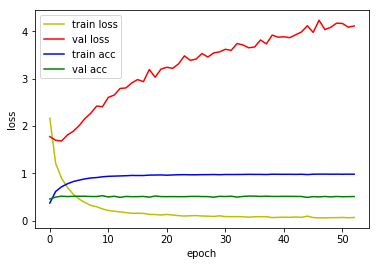

4815/4815 [==============================] - 3s 701us/sample - loss: 1.7584 - acc: 0.4914
Loss: 1.75843371575 Accuracy: 0.4913811

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.9640 - acc: 0.3921
Epoch 00001: val_loss improved from inf to 2.92034, saving model to model/checkpoint/1D_CNN_2_only_conv_pool_3_ch_64_DO_BN_checkpoint/001-2.9203.hdf5
36805/36805 [==============================] - 69s 2ms/sample - loss: 2.9641 - acc: 0.3921 - val_loss: 2.9203 - val_acc: 0.3049
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7016 - acc: 0.6162
Epoch 00002: val_loss improved from 2.92034 to 1.92215, saving model to model/checkpoint/1D_CNN_2_only_conv_pool_3_ch_64_DO_BN_checkpoint/002-1.9222.hdf5
36805/36805 [==============================] - 53s 1ms/sample - loss: 1.7016 - acc: 0.6162 - val_loss: 1.9222 - val_acc: 0.5798
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s -

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1670 - acc: 0.9680
Epoch 00029: val_loss did not improve from 1.73920
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.1672 - acc: 0.9679 - val_loss: 2.3576 - val_acc: 0.7349
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1581 - acc: 0.9708
Epoch 00030: val_loss did not improve from 1.73920
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.1581 - acc: 0.9708 - val_loss: 2.3086 - val_acc: 0.7303
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1368 - acc: 0.9747
Epoch 00031: val_loss did not improve from 1.73920
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.1368 - acc: 0.9747 - val_loss: 2.4499 - val_acc: 0.7289
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1310 - acc: 0.9763
Epoch 00032: val_loss did not improve from 1.73920
36805/36805 [===========

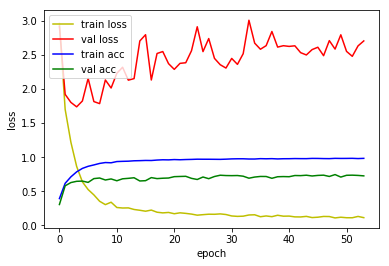

4815/4815 [==============================] - 4s 807us/sample - loss: 1.8647 - acc: 0.6120
Loss: 1.8646544635481552 Accuracy: 0.6120457

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5723 - acc: 0.4341
Epoch 00001: val_loss improved from inf to 9.32586, saving model to model/checkpoint/1D_CNN_3_only_conv_pool_3_ch_64_DO_BN_checkpoint/001-9.3259.hdf5
36805/36805 [==============================] - 84s 2ms/sample - loss: 2.5724 - acc: 0.4340 - val_loss: 9.3259 - val_acc: 0.1409
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5911 - acc: 0.6368
Epoch 00002: val_loss improved from 9.32586 to 1.36779, saving model to model/checkpoint/1D_CNN_3_only_conv_pool_3_ch_64_DO_BN_checkpoint/002-1.3678.hdf5
36805/36805 [==============================] - 64s 2ms/sample - loss: 1.5910 - acc: 0.6368 - val_loss: 1.3678 - val_acc: 0.6823
Epoch 3/500
36800/36805 [============================>.] - ETA:

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1131 - acc: 0.9755
Epoch 00028: val_loss did not improve from 0.96732
36805/36805 [==============================] - 64s 2ms/sample - loss: 0.1131 - acc: 0.9755 - val_loss: 1.3638 - val_acc: 0.8132
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1104 - acc: 0.9756
Epoch 00029: val_loss did not improve from 0.96732
36805/36805 [==============================] - 63s 2ms/sample - loss: 0.1103 - acc: 0.9756 - val_loss: 1.5265 - val_acc: 0.8104
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1119 - acc: 0.9765
Epoch 00030: val_loss did not improve from 0.96732
36805/36805 [==============================] - 64s 2ms/sample - loss: 0.1123 - acc: 0.9765 - val_loss: 1.2399 - val_acc: 0.8374
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1138 - acc: 0.9751
Epoch 00031: val_loss did not improve from 0.96732
36805/36805 [===========

Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0724 - acc: 0.9874
Epoch 00058: val_loss did not improve from 0.96732
36805/36805 [==============================] - 64s 2ms/sample - loss: 0.0724 - acc: 0.9874 - val_loss: 1.4379 - val_acc: 0.8458
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0659 - acc: 0.9883
Epoch 00059: val_loss did not improve from 0.96732
36805/36805 [==============================] - 64s 2ms/sample - loss: 0.0659 - acc: 0.9883 - val_loss: 1.2943 - val_acc: 0.8614
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0773 - acc: 0.9861
Epoch 00060: val_loss did not improve from 0.96732
36805/36805 [==============================] - 64s 2ms/sample - loss: 0.0777 - acc: 0.9861 - val_loss: 1.3144 - val_acc: 0.8528

1D_CNN_3_only_conv_pool_3_ch_64_DO_BN Model


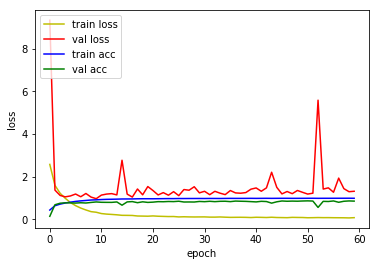

4815/4815 [==============================] - 4s 911us/sample - loss: 1.0700 - acc: 0.7913
Loss: 1.0699720343572947 Accuracy: 0.7912772

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2170 - acc: 0.4283
Epoch 00001: val_loss improved from inf to 8.04232, saving model to model/checkpoint/1D_CNN_4_only_conv_pool_3_ch_64_DO_BN_checkpoint/001-8.0423.hdf5
36805/36805 [==============================] - 93s 3ms/sample - loss: 2.2170 - acc: 0.4282 - val_loss: 8.0423 - val_acc: 0.1628
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2546 - acc: 0.6549
Epoch 00002: val_loss improved from 8.04232 to 0.82781, saving model to model/checkpoint/1D_CNN_4_only_conv_pool_3_ch_64_DO_BN_checkpoint/002-0.8278.hdf5
36805/36805 [==============================] - 69s 2ms/sample - loss: 1.2546 - acc: 0.6549 - val_loss: 0.8278 - val_acc: 0.7615
Epoch 3/500
36800/36805 [============================>.] - ETA:

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0282 - acc: 0.9913
Epoch 00057: val_loss did not improve from 0.33892
36805/36805 [==============================] - 69s 2ms/sample - loss: 0.0283 - acc: 0.9913 - val_loss: 0.4522 - val_acc: 0.9278
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0320 - acc: 0.9899
Epoch 00058: val_loss did not improve from 0.33892
36805/36805 [==============================] - 69s 2ms/sample - loss: 0.0320 - acc: 0.9899 - val_loss: 0.4055 - val_acc: 0.9352
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0241 - acc: 0.9927
Epoch 00059: val_loss did not improve from 0.33892
36805/36805 [==============================] - 69s 2ms/sample - loss: 0.0241 - acc: 0.9927 - val_loss: 0.5019 - val_acc: 0.9259
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0213 - acc: 0.9935
Epoch 00060: val_loss did not improve from 0.33892
36805/36805 [===========

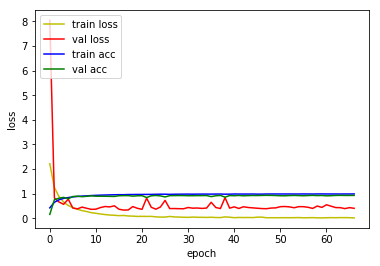

4815/4815 [==============================] - 5s 997us/sample - loss: 0.4124 - acc: 0.8980
Loss: 0.41239267073316366 Accuracy: 0.898027

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8690 - acc: 0.4870
Epoch 00001: val_loss improved from inf to 6.06471, saving model to model/checkpoint/1D_CNN_5_only_conv_pool_3_ch_64_DO_BN_checkpoint/001-6.0647.hdf5
36805/36805 [==============================] - 102s 3ms/sample - loss: 1.8688 - acc: 0.4870 - val_loss: 6.0647 - val_acc: 0.1912
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8766 - acc: 0.7451
Epoch 00002: val_loss improved from 6.06471 to 0.49237, saving model to model/checkpoint/1D_CNN_5_only_conv_pool_3_ch_64_DO_BN_checkpoint/002-0.4924.hdf5
36805/36805 [==============================] - 72s 2ms/sample - loss: 0.8765 - acc: 0.7451 - val_loss: 0.4924 - val_acc: 0.8591
Epoch 3/500
36800/36805 [============================>.] - ETA

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0244 - acc: 0.9922
Epoch 00056: val_loss did not improve from 0.19551
36805/36805 [==============================] - 72s 2ms/sample - loss: 0.0244 - acc: 0.9922 - val_loss: 0.2775 - val_acc: 0.9502
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0140 - acc: 0.9958
Epoch 00057: val_loss did not improve from 0.19551
36805/36805 [==============================] - 72s 2ms/sample - loss: 0.0140 - acc: 0.9958 - val_loss: 0.2195 - val_acc: 0.9562
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0127 - acc: 0.9959
Epoch 00058: val_loss did not improve from 0.19551
36805/36805 [==============================] - 72s 2ms/sample - loss: 0.0128 - acc: 0.9959 - val_loss: 0.2672 - val_acc: 0.9525
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0209 - acc: 0.9933
Epoch 00059: val_loss did not improve from 0.19551
36805/36805 [===========

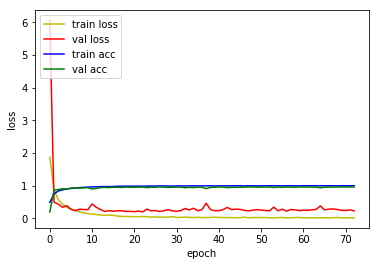

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.2441 - acc: 0.9408
Loss: 0.24407205073199664 Accuracy: 0.94080997

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6317 - acc: 0.5473
Epoch 00001: val_loss improved from inf to 5.36685, saving model to model/checkpoint/1D_CNN_6_only_conv_pool_3_ch_64_DO_BN_checkpoint/001-5.3668.hdf5
36805/36805 [==============================] - 110s 3ms/sample - loss: 1.6319 - acc: 0.5472 - val_loss: 5.3668 - val_acc: 0.2008
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6957 - acc: 0.7888
Epoch 00002: val_loss improved from 5.36685 to 0.44272, saving model to model/checkpoint/1D_CNN_6_only_conv_pool_3_ch_64_DO_BN_checkpoint/002-0.4427.hdf5
36805/36805 [==============================] - 75s 2ms/sample - loss: 0.6960 - acc: 0.7888 - val_loss: 0.4427 - val_acc: 0.8630
Epoch 3/500
36800/36805 [============================>.] - ETA

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0160 - acc: 0.9951
Epoch 00056: val_loss did not improve from 0.12595
36805/36805 [==============================] - 75s 2ms/sample - loss: 0.0160 - acc: 0.9951 - val_loss: 0.1532 - val_acc: 0.9672
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0090 - acc: 0.9974
Epoch 00057: val_loss did not improve from 0.12595
36805/36805 [==============================] - 75s 2ms/sample - loss: 0.0091 - acc: 0.9974 - val_loss: 0.1659 - val_acc: 0.9618
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0152 - acc: 0.9950
Epoch 00058: val_loss did not improve from 0.12595
36805/36805 [==============================] - 75s 2ms/sample - loss: 0.0152 - acc: 0.9950 - val_loss: 0.1652 - val_acc: 0.9655
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0090 - acc: 0.9972
Epoch 00059: val_loss did not improve from 0.12595
36805/36805 [===========

Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0089 - acc: 0.9974
Epoch 00086: val_loss did not improve from 0.12595
36805/36805 [==============================] - 75s 2ms/sample - loss: 0.0089 - acc: 0.9974 - val_loss: 0.1828 - val_acc: 0.9602
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0080 - acc: 0.9977
Epoch 00087: val_loss did not improve from 0.12595
36805/36805 [==============================] - 75s 2ms/sample - loss: 0.0080 - acc: 0.9977 - val_loss: 0.1635 - val_acc: 0.9662

1D_CNN_6_only_conv_pool_3_ch_64_DO_BN Model


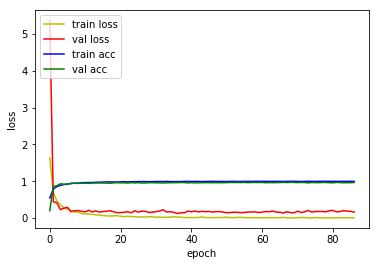

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.2012 - acc: 0.9537
Loss: 0.2012356050045598 Accuracy: 0.9536864



In [18]:
for i in range(1, 7):
    model_name = '1D_CNN_{}_only_conv_pool_3_ch_64_DO_BN'.format(i)
    model = build_1d_cnn_only_conv_pool_3_ch_64_DO_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [19]:
for i in range(1, 7):
    model_name = '1D_CNN_{}_only_conv_pool_3_ch_64_DO_BN'.format(i)
    print()
    print(model_name, 'Model')
#         model = build_cnn(conv_num=i, fcn_num=j)
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
#         model_filename = model_path + '{epoch:02d}-{val_loss:.4f}.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


1D_CNN_1_only_conv_pool_3_ch_64_DO_BN Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_105 (Conv1D)          (None, 15976, 64)         1664      
_________________________________________________________________
batch_normalization_v1_63 (B (None, 15976, 64)         256       
_________________________________________________________________
max_pooling1d_105 (MaxPoolin (None, 5326, 64)          0         
_________________________________________________________________
flatten_30 (Flatten)         (None, 340864)            0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 340864)            0         
_________________________________________________________________
dense_30 (Dense)             (None, 16)                5453840   
Total params: 5,455,760
Trainable params: 5,455,632
Non-trainable params: 128
___________________

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.2441 - acc: 0.9408
Loss: 0.24407205073199664 Accuracy: 0.94080997

1D_CNN_6_only_conv_pool_3_ch_64_DO_BN Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_120 (Conv1D)          (None, 15976, 64)         1664      
_________________________________________________________________
batch_normalization_v1_78 (B (None, 15976, 64)         256       
_________________________________________________________________
max_pooling1d_120 (MaxPoolin (None, 5326, 64)          0         
_________________________________________________________________
conv1d_121 (Conv1D)          (None, 5302, 64)          102464    
_________________________________________________________________
batch_normalization_v1_79 (B (None, 5302, 64)          256       
_________________________________________________________________
max_pooling1d_121 (MaxPoolin